# *Fit* Model to Data

Untuk contoh, digunakan data okultasi HD 12730

### Data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

plt.style.use(['science', 'notebook', 'grid'])

In [2]:
df = pd.read_csv("hd12730.csv", sep=',')
df.head()

,FrameNum,timeInfo,signal-obj,appsum-obj,avgbkg-obj,stdbkg-obj,nmaskpx-obj,maxpx-obj,xcentroid-obj,ycentroid-obj
0,1801.0,[20:43:44.9909103],-3338.0,327456.0,8940.39,1518.21,-37,15504,171.0,233.0
1,1802.0,[20:43:45.0240076],-450.0,332960.0,9011.09,1535.88,-37,14080,171.0,233.0
2,1803.0,[20:43:45.0571090],7806.0,339520.0,8965.23,1582.49,-37,14480,171.0,233.0
3,1804.0,[20:43:45.0902105],-445.0,332560.0,9000.13,1527.86,-37,14704,171.0,233.0
4,1805.0,[20:43:45.1233119],-6939.0,323744.0,8937.38,1570.19,-37,14256,171.0,233.0


In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

,FrameNum,timeInfo,signal-obj,appsum-obj,avgbkg-obj,stdbkg-obj,nmaskpx-obj,maxpx-obj,xcentroid-obj,ycentroid-obj
0,1801.0,2022-06-17 20:43:44.990910,-3338.0,327456.0,8940.39,1518.21,-37,15504,171.0,233.0
1,1802.0,2022-06-17 20:43:45.024007,-450.0,332960.0,9011.09,1535.88,-37,14080,171.0,233.0
2,1803.0,2022-06-17 20:43:45.057109,7806.0,339520.0,8965.23,1582.49,-37,14480,171.0,233.0
3,1804.0,2022-06-17 20:43:45.090210,-445.0,332560.0,9000.13,1527.86,-37,14704,171.0,233.0
4,1805.0,2022-06-17 20:43:45.123311,-6939.0,323744.0,8937.38,1570.19,-37,14256,171.0,233.0


In [4]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Time', 'Value']
data.head()

,Frame,Time,Value
0,1801.0,2022-06-17 20:43:44.990910,-3338.0
1,1802.0,2022-06-17 20:43:45.024007,-450.0
2,1803.0,2022-06-17 20:43:45.057109,7806.0
3,1804.0,2022-06-17 20:43:45.090210,-445.0
4,1805.0,2022-06-17 20:43:45.123311,-6939.0


Text(0.5, 0, 'Frames')

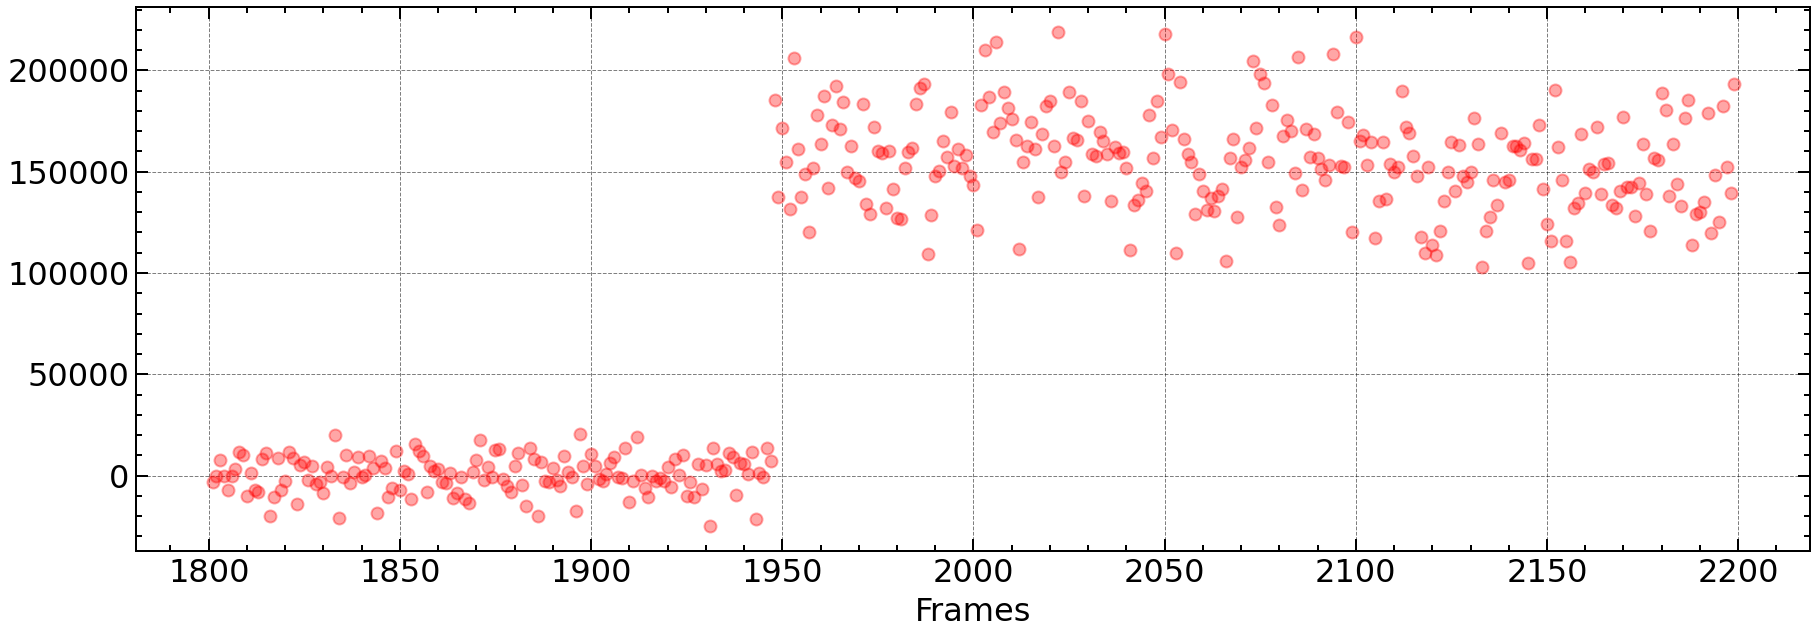

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Normalisasi data pengamatan

In [6]:
value_scaled = data['Value']/(data['Value'].std()*2)

Text(0.5, 0, 'Frames')

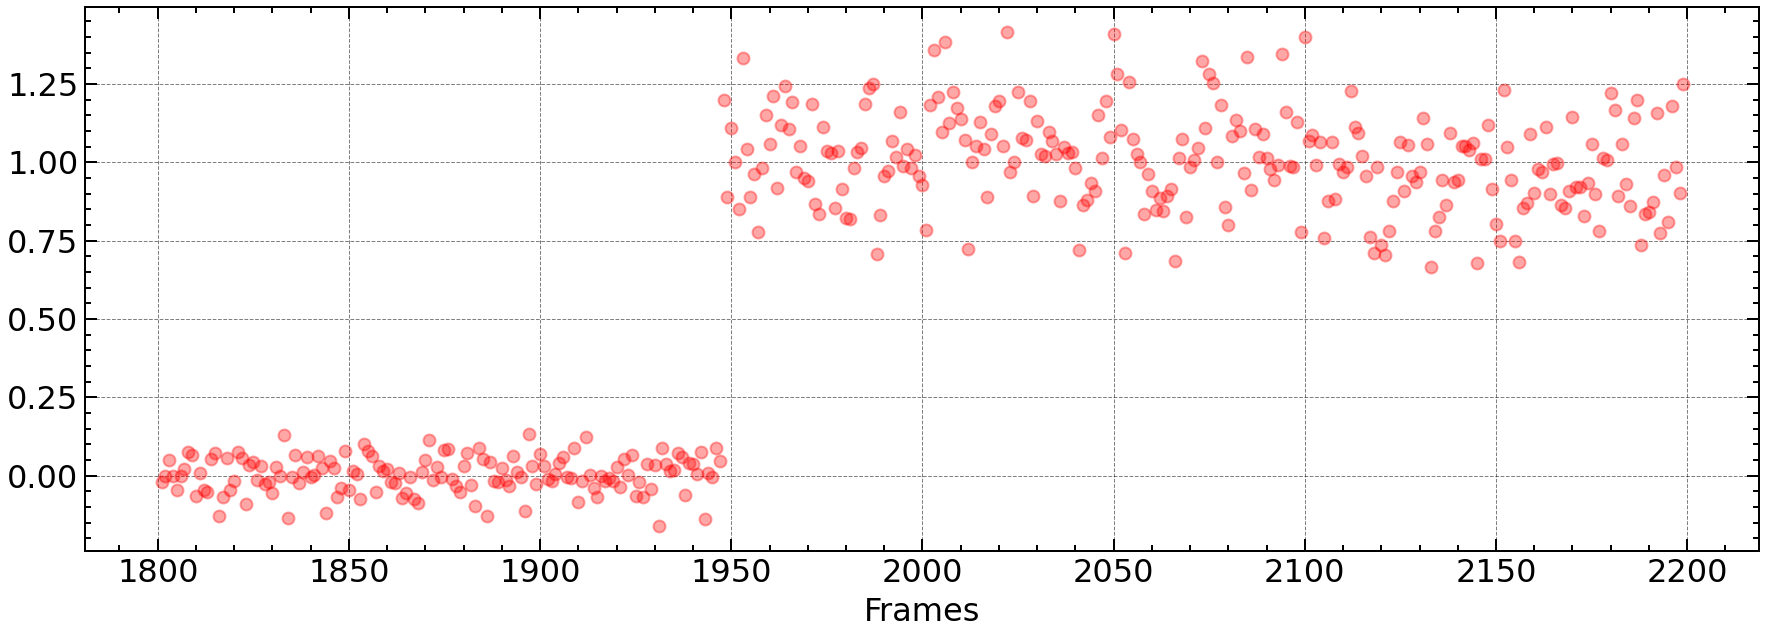

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], value_scaled, 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Kurva benda hitam untuk HD 12730, $T = 5240$ K

Fungsi kurva benda hitam:

In [8]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

In [9]:
x_axis = np.arange(100, 2000)

In [10]:
y_axis = Planck(x_axis, 5240)

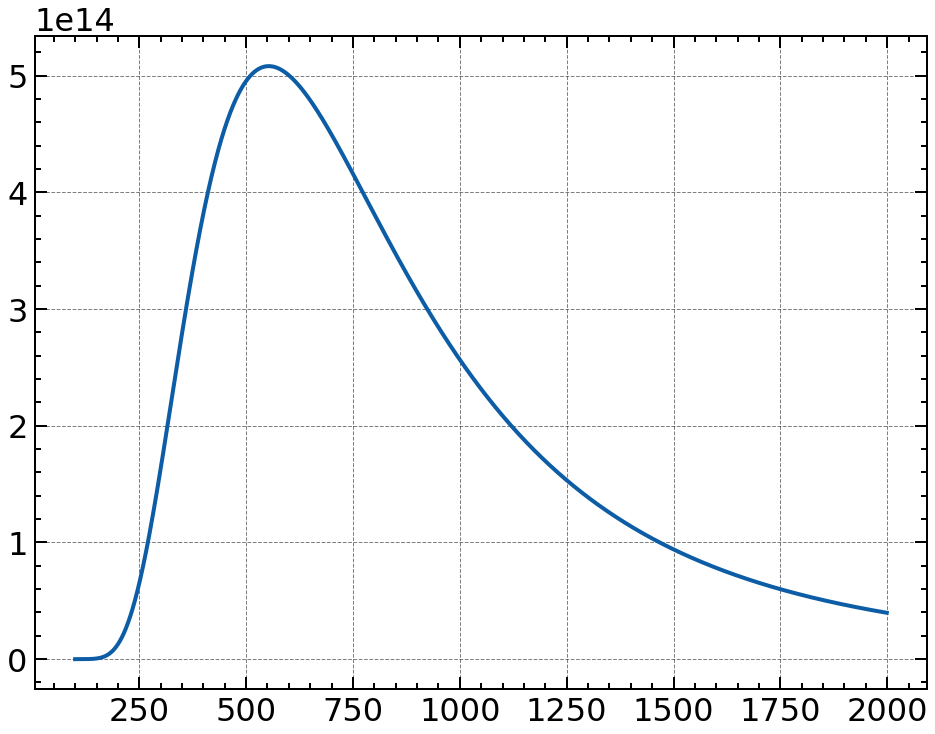

In [11]:
plt.plot(x_axis, y_axis)

In [12]:
den = np.max(y_axis)

y_val = y_axis/den

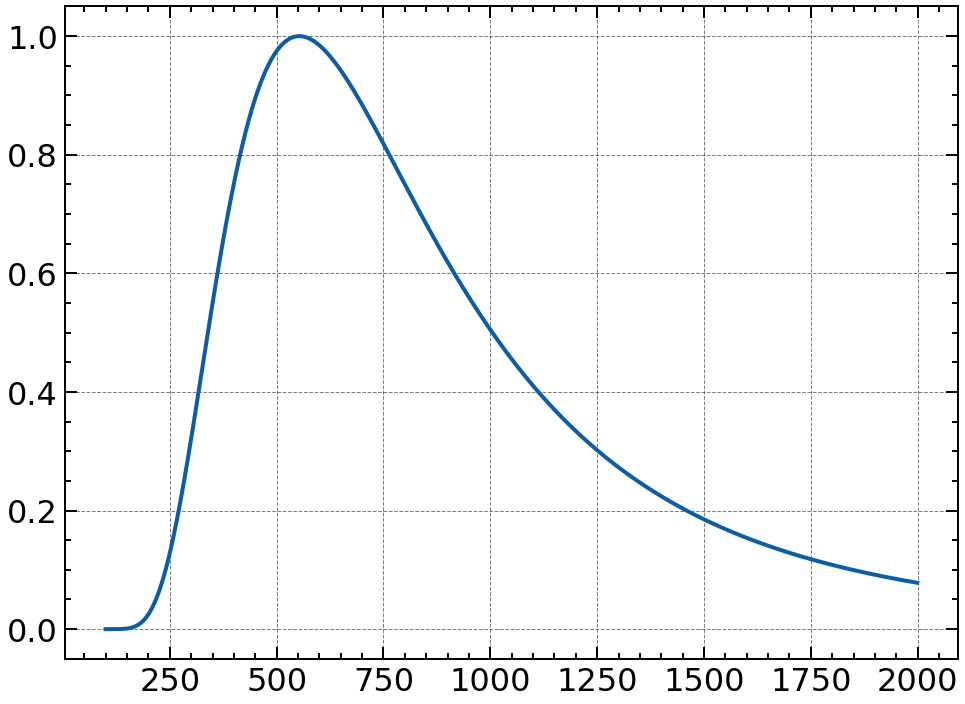

In [13]:
plt.plot(x_axis, y_val)

### Kurva Transmisi

Untuk keperluan ini digunakan *response curve* dari kamera QHY 174M GPS mode tanpa filter.

In [14]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

,wavelength,response
0,200.0,0.0
1,210.0,0.0
2,220.0,0.0
3,230.0,0.0
4,240.0,0.0


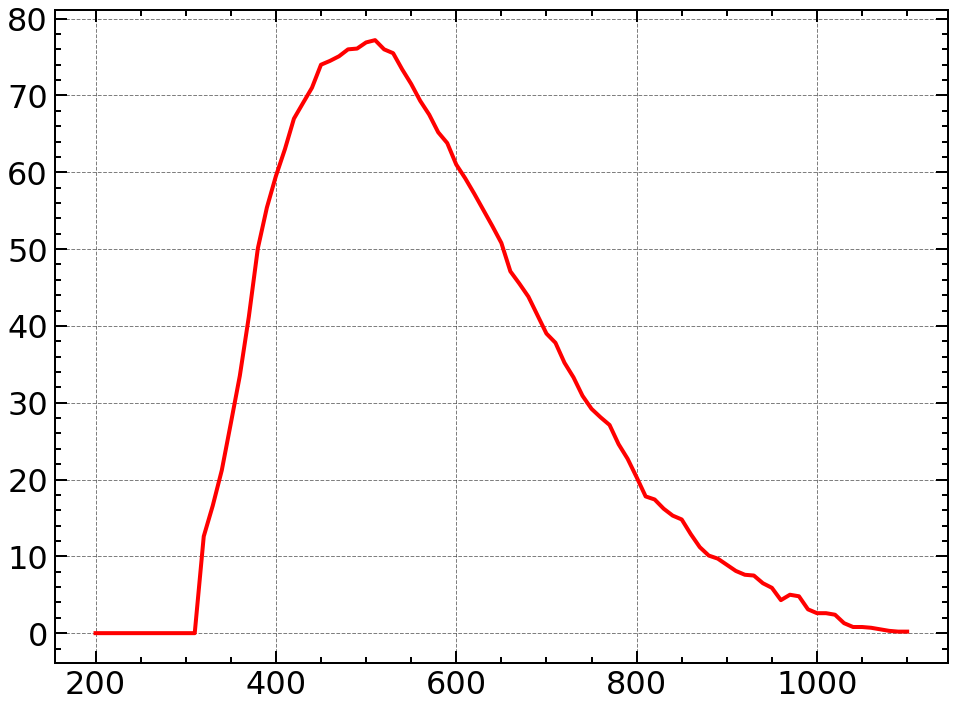

In [15]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [16]:
bandwidth = np.arange(330, 1100, 10) # rentang sesuai kurva transmisi

bandwidth

array([ 330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090])

In [17]:
f_interp = interp1d(x, y, kind='cubic')

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal 13 Juli 2020 pukul 20:43:47.8 UT. Ephemeris diambil dari https://ssd.jpl.nasa.gov/ftp/eph/planets/ascii/

In [18]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2020, 7, 13, 20, 43, 47.8)

In [19]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [20]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [21]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

02h 02m 46.00s
+07deg 46' 19.6"
403447.29083487095


In [22]:
d_moon = distance.km
d_moon

403447.29083487095

### Model

In [23]:
x_data = np.array(data['Frame'])
y_data = np.array(data['Value'])

In [24]:
# x_data2 = np.flip(x_data)

In [25]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [26]:
# Variabel benar
# -------------
x0_true = 1950
A_true = 65
σ_true = 20000
T = 5240.

In [27]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

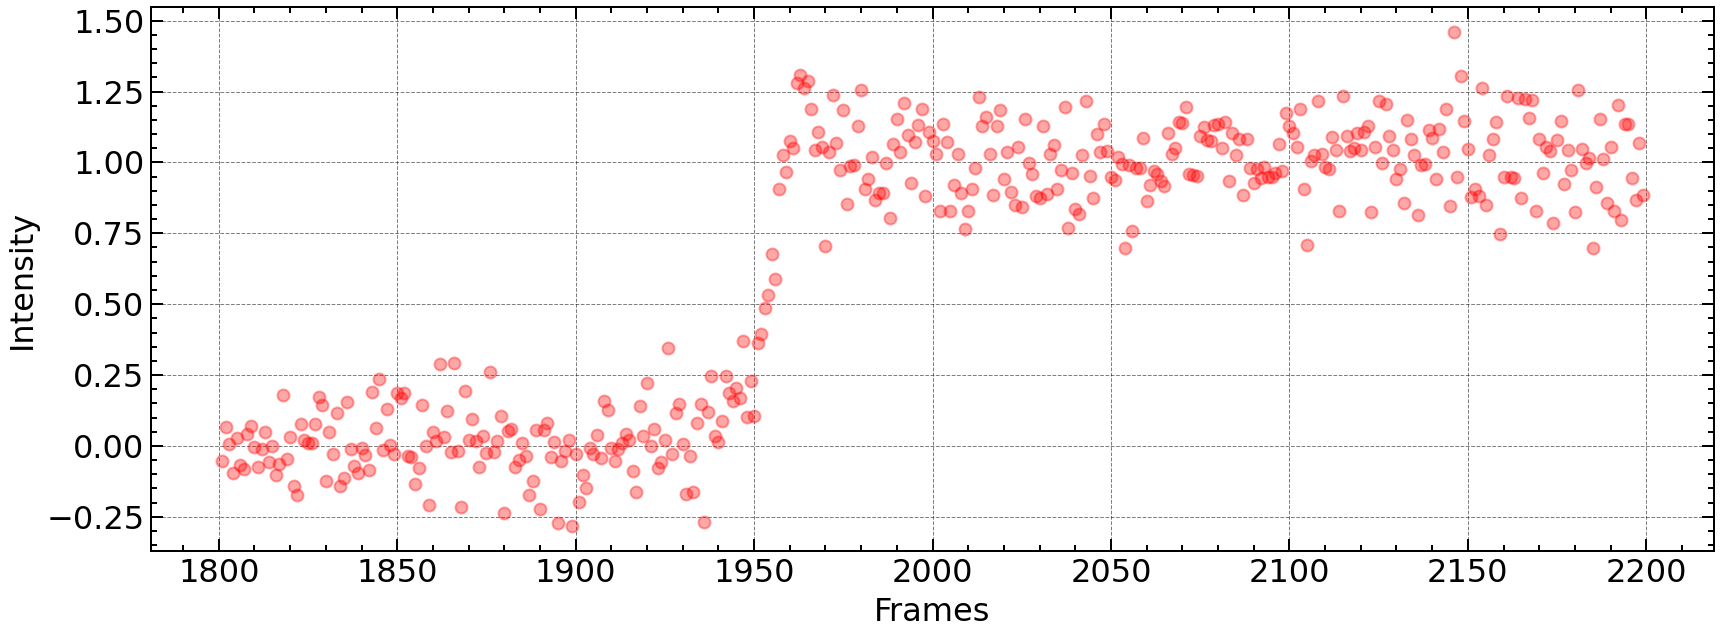

In [28]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [29]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

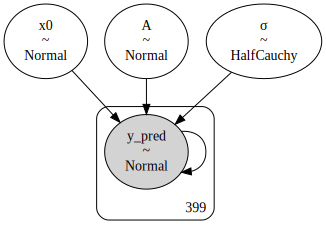

In [30]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=1950., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [31]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 841 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

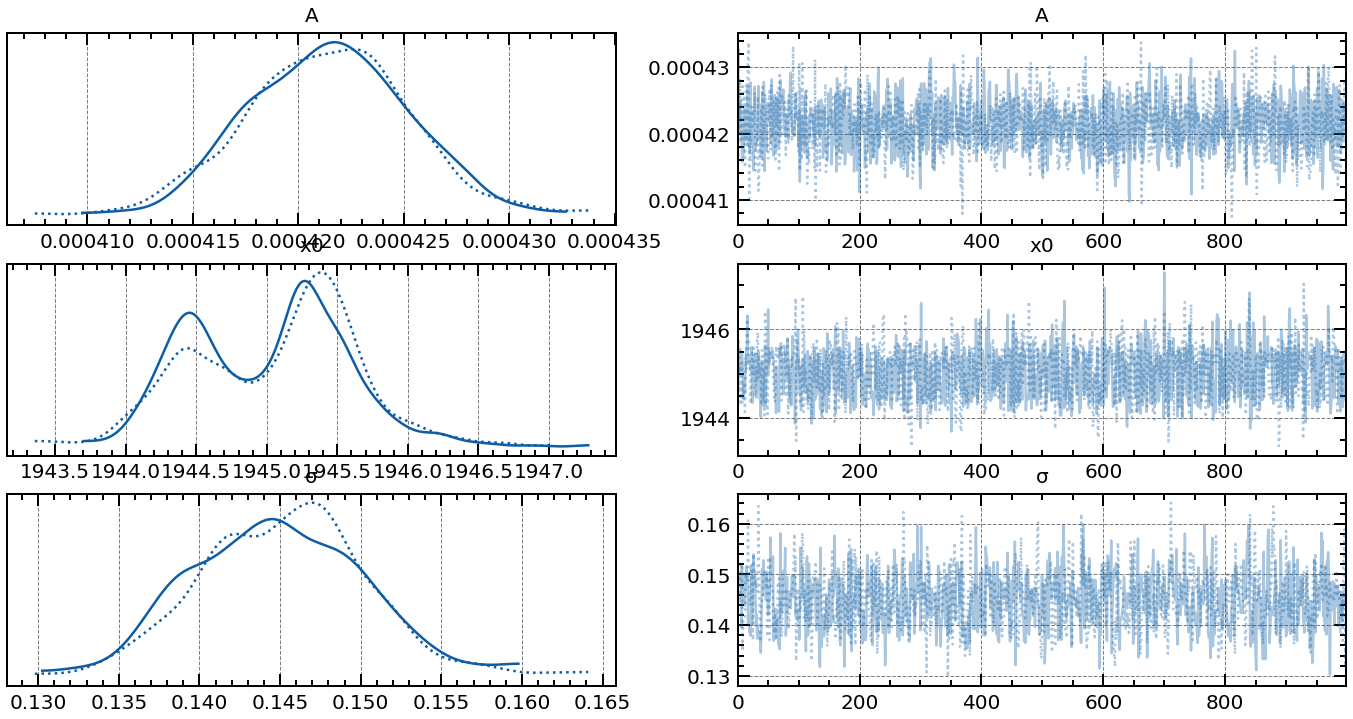

In [32]:
az.plot_trace(idata)

In [33]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.000,0.000,0.000,0.000,0.000,0.00,1606.0,1364.0,1.0
x0,1945.035,0.572,1944.011,1945.982,0.014,0.01,1639.0,1424.0,1.0
σ,0.145,0.005,0.135,0.154,0.000,0.00,998.0,1461.0,1.0


In [34]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [35]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

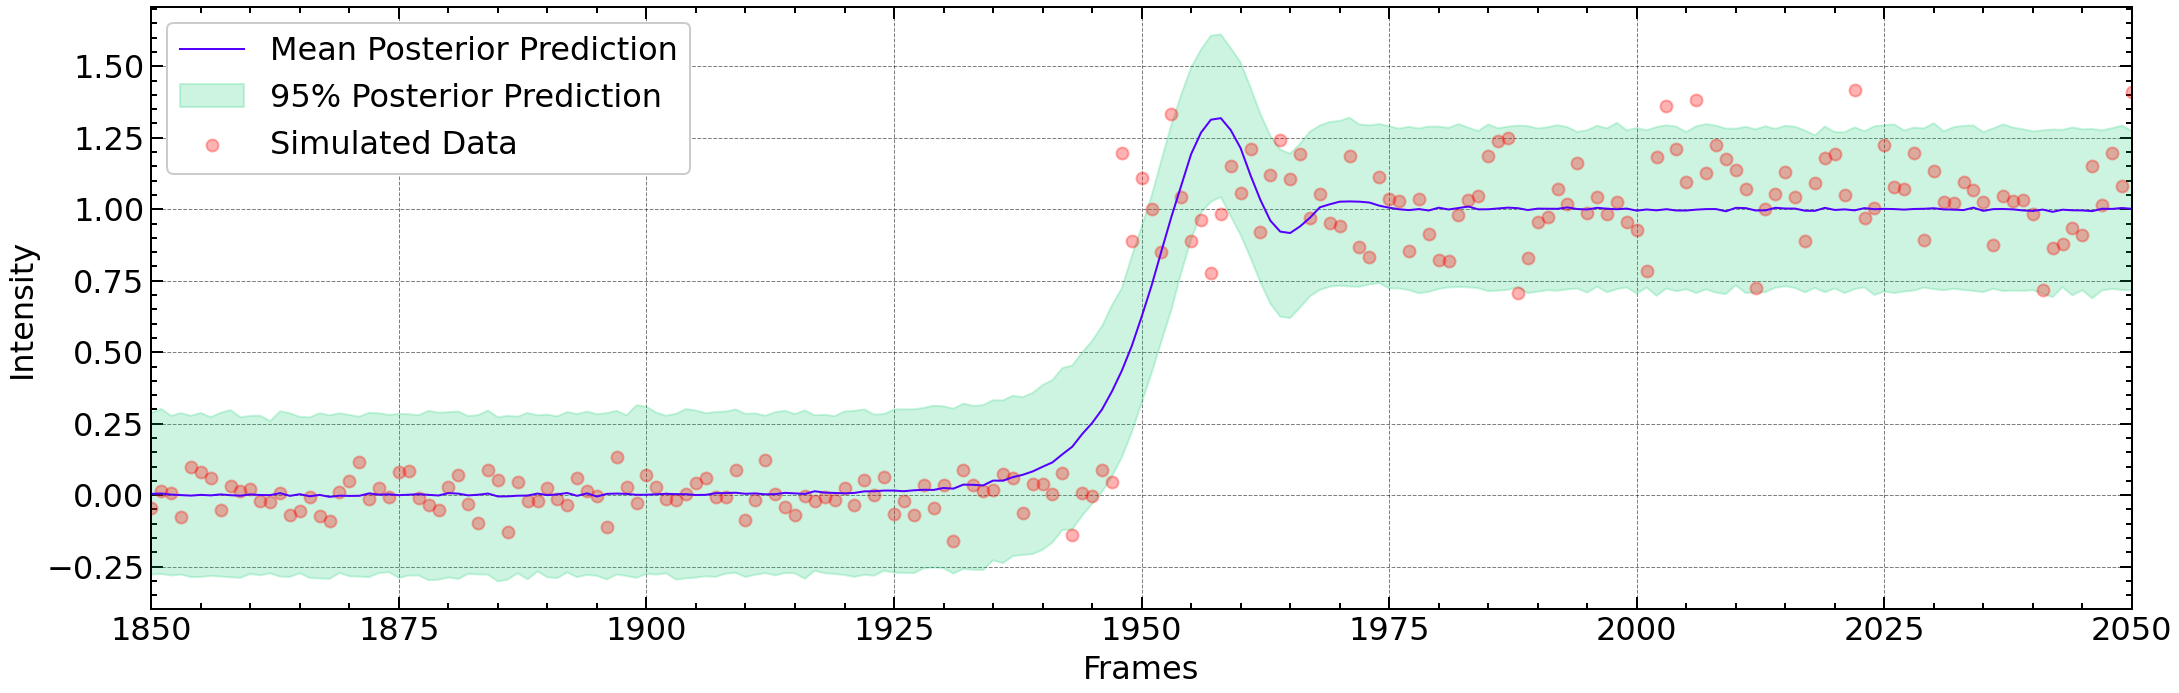

In [36]:
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
plt.xlim(1850, 2050)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

### Data HD 211038

In [37]:
df = pd.read_csv("HD211038-b.csv", sep=',')
df.head()

,FrameNum,timeInfo,signal-track,signal-obj,appsum-track,avgbkg-track,stdbkg-track,nmaskpx-track,maxpx-track,xcentroid-track,ycentroid-track,appsum-obj,avgbkg-obj,stdbkg-obj,nmaskpx-obj,maxpx-obj,xcentroid-obj,ycentroid-obj
0,1401.0,[17:48:21.8008202],7009.0,-8542.0,563504.0,15040.40,358.28,-37,17552,221.0,273.0,1064096.0,28990.22,2079.95,-37,38704,187.0,128.0
1,1402.0,[17:48:21.8339216],6185.0,-8899.0,562720.0,15041.48,360.31,-37,18016,221.0,273.0,1063248.0,28976.96,2078.54,-37,39904,187.0,128.0
2,1403.0,[17:48:21.8670230],5370.0,-8948.0,561840.0,15039.73,305.92,-37,17104,221.0,273.0,1058752.0,28856.75,2038.57,-37,37968,187.0,128.0
3,1404.0,[17:48:21.9001243],8657.0,-11101.0,566560.0,15078.45,341.18,-37,17696,221.0,273.0,1060384.0,28959.05,2084.82,-37,37552,187.0,128.0
4,1405.0,[17:48:21.9332257],7629.0,-7424.0,563472.0,15022.79,327.23,-37,17232,221.0,273.0,1064016.0,28957.83,2109.99,-37,39152,187.0,128.0


In [38]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

,FrameNum,timeInfo,signal-track,signal-obj,appsum-track,avgbkg-track,stdbkg-track,nmaskpx-track,maxpx-track,xcentroid-track,ycentroid-track,appsum-obj,avgbkg-obj,stdbkg-obj,nmaskpx-obj,maxpx-obj,xcentroid-obj,ycentroid-obj
0,1401.0,2022-06-17 17:48:21.800820,7009.0,-8542.0,563504.0,15040.40,358.28,-37,17552,221.0,273.0,1064096.0,28990.22,2079.95,-37,38704,187.0,128.0
1,1402.0,2022-06-17 17:48:21.833921,6185.0,-8899.0,562720.0,15041.48,360.31,-37,18016,221.0,273.0,1063248.0,28976.96,2078.54,-37,39904,187.0,128.0
2,1403.0,2022-06-17 17:48:21.867023,5370.0,-8948.0,561840.0,15039.73,305.92,-37,17104,221.0,273.0,1058752.0,28856.75,2038.57,-37,37968,187.0,128.0
3,1404.0,2022-06-17 17:48:21.900124,8657.0,-11101.0,566560.0,15078.45,341.18,-37,17696,221.0,273.0,1060384.0,28959.05,2084.82,-37,37552,187.0,128.0
4,1405.0,2022-06-17 17:48:21.933225,7629.0,-7424.0,563472.0,15022.79,327.23,-37,17232,221.0,273.0,1064016.0,28957.83,2109.99,-37,39152,187.0,128.0


In [39]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Time', 'Value']
data.head()

,Frame,Time,Value
0,1401.0,2022-06-17 17:48:21.800820,-8542.0
1,1402.0,2022-06-17 17:48:21.833921,-8899.0
2,1403.0,2022-06-17 17:48:21.867023,-8948.0
3,1404.0,2022-06-17 17:48:21.900124,-11101.0
4,1405.0,2022-06-17 17:48:21.933225,-7424.0


Text(0.5, 0, 'Frames')

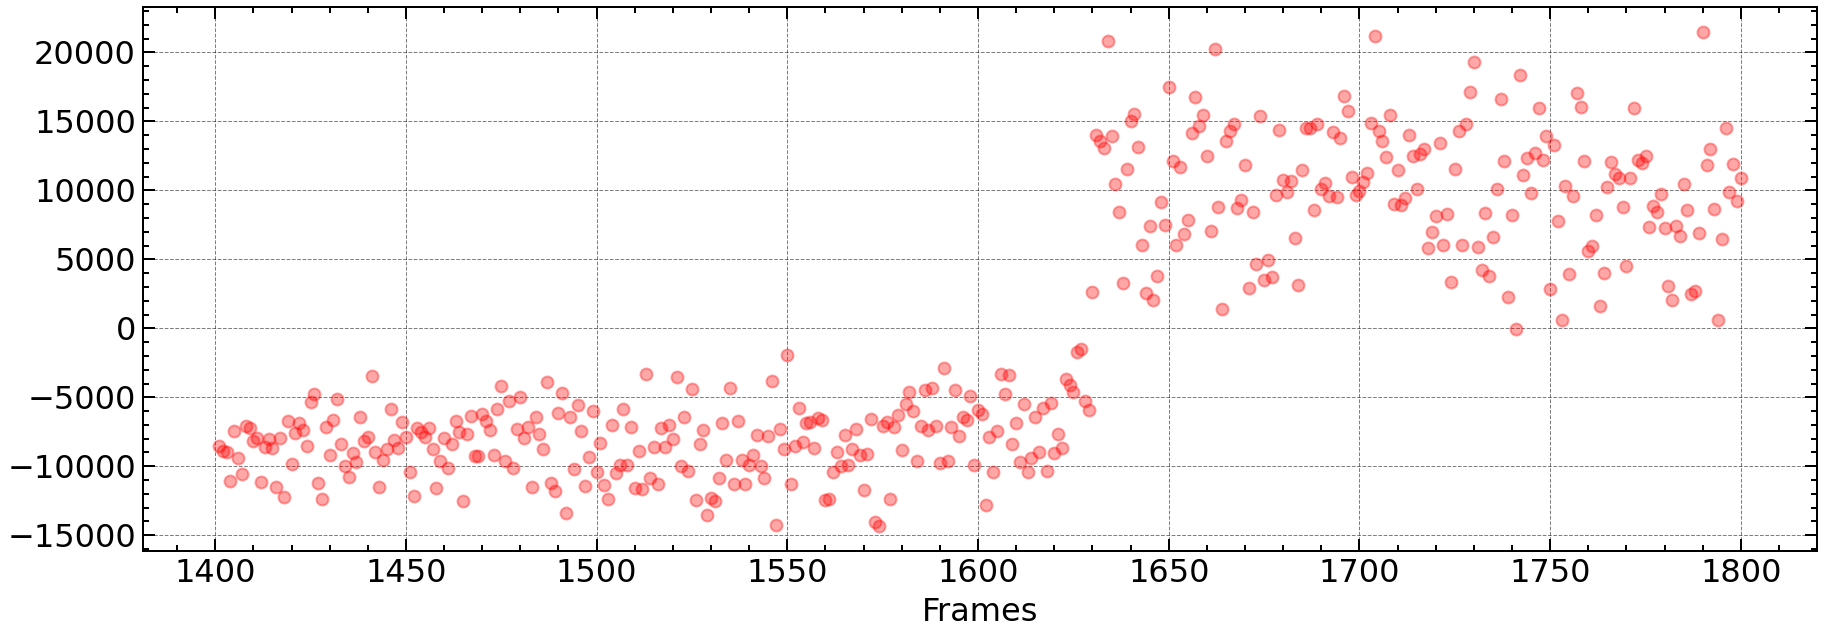

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Normalisasi

In [41]:
value2_scaled = data['Value'] / (data['Value'].std()*2) 

Text(0.5, 0, 'Frames')

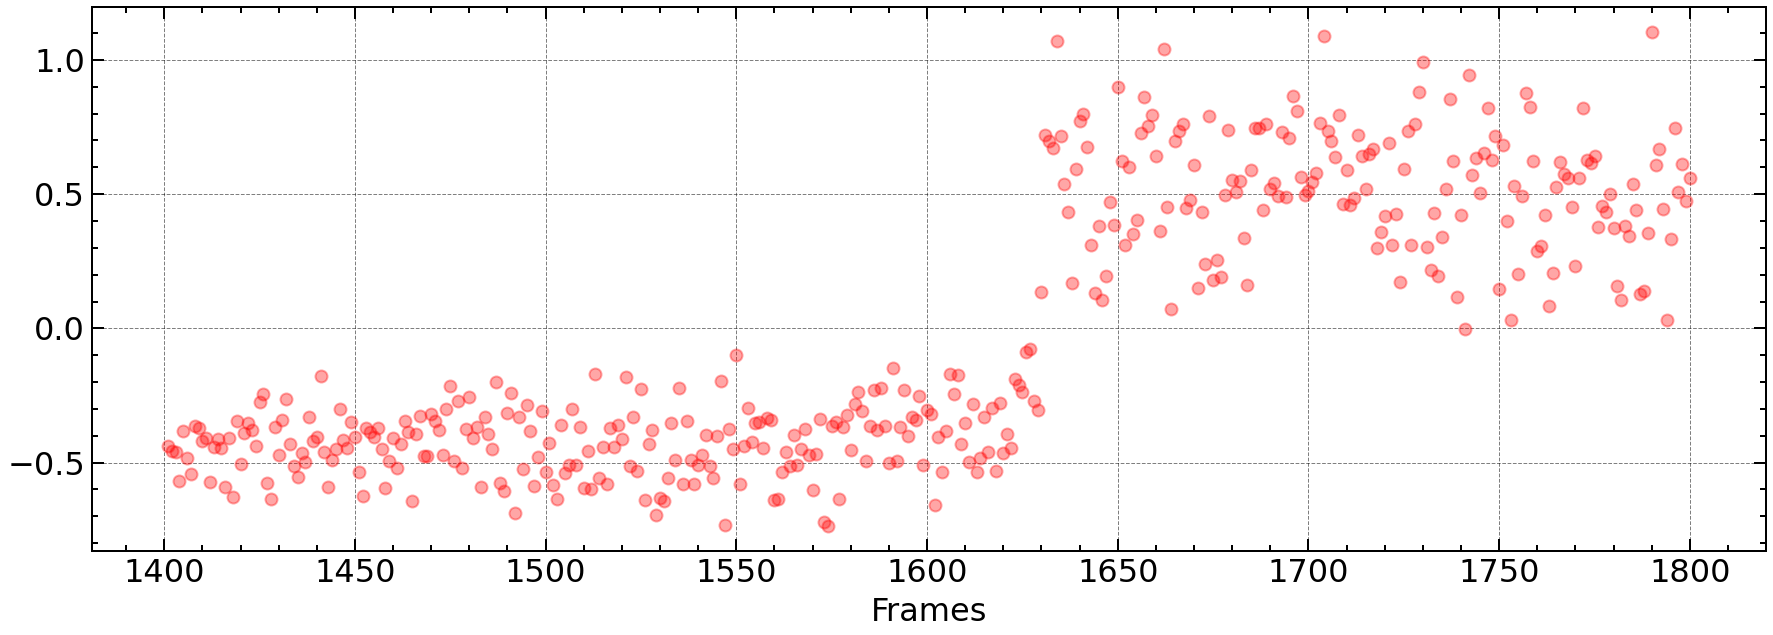

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], value2_scaled, 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Data sintetik HD 211038

In [43]:
x_data2 = np.array(data['Frame'])
y_data2 = np.array(data['Value'])

In [44]:
t2 = ts.utc(2020, 7, 8, 17, 48, 35)

astrometric2 = earth.at(t2).observe(moon)
ra2, dec2, distance2 = astrometric2.radec()

print(distance2.km)

394667.9810011528


In [45]:
# Variabel benar
# -------------
x0_true2 = 1635
A_true2 = 8
σ_true2 = 2000
T2 = 5300.
β = -10000
d_moon2 = distance2.km

In [46]:
def fresnel_polikromatik2(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T2)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0 + β

In [47]:
y_syn2 = fresnel_polikromatik2(x_data2, x0_true2, d_moon2, A_true2)
y_syn2 = np.random.normal(y_syn2, scale=σ_true2)

y_syn2_scaled = y_syn2 / (y_syn2.std()*2)

Text(0, 0.5, 'Intensity')

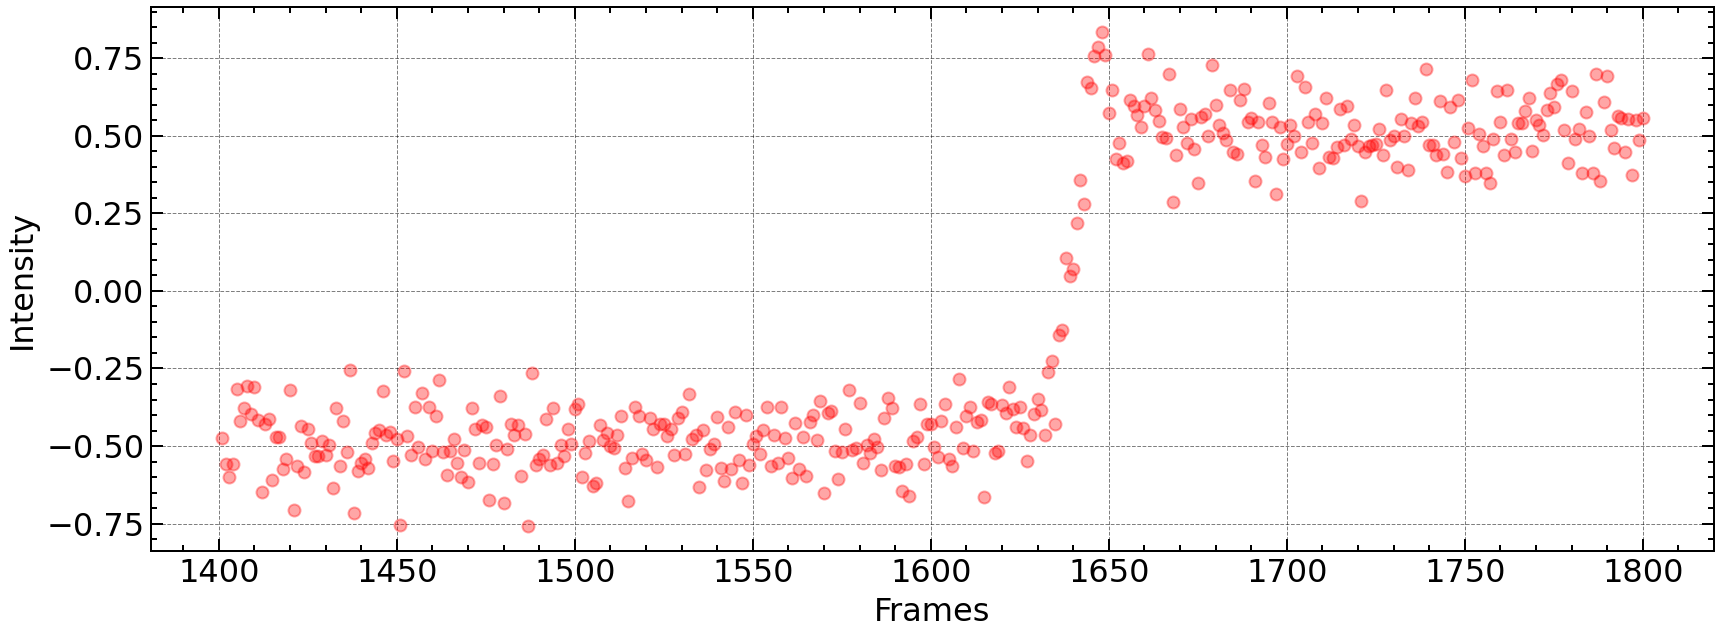

In [48]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data2, y_syn2_scaled, marker='o', c='r', alpha=0.35)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [49]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik2(x, x0, d, A, β):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T2)/den) * y
        y0 += y_new
    return y0 + β

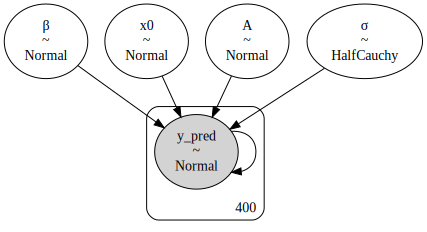

In [50]:
x_shared2 = aesara.shared(x_data2)
d_shared2 = aesara.shared(d_moon2)

with pm.Model() as model_polikromatik2:
    A = pm.Normal('A', mu=0.5, sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=1635., sigma=1.)
    β = pm.Normal('β', mu=-0.5, sigma=1.)
    
    μ = t_fresnel_polikromatik2(x_shared2, x0, d_shared2, A, β)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value2_scaled)
    
pm.model_to_graphviz(model_polikromatik2)

In [51]:
with model_polikromatik2:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>>Slice: [β]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 884 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

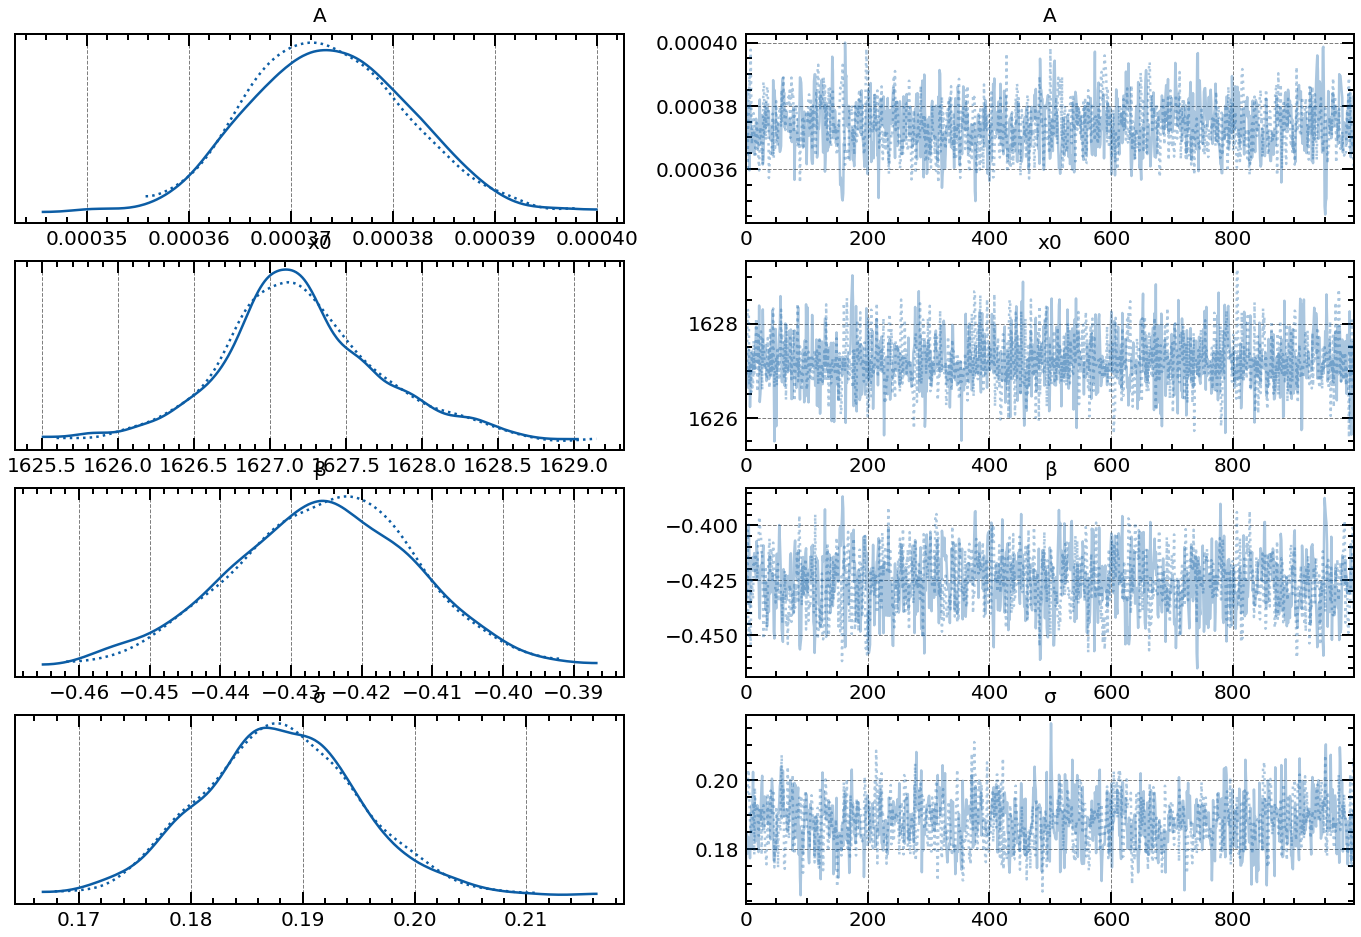

In [52]:
az.plot_trace(idata)

In [53]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.000,0.000,0.000,0.000,0.000,0.00,796.0,921.0,1.0
x0,1627.202,0.532,1626.320,1628.410,0.014,0.01,1537.0,1424.0,1.0
β,-0.426,0.013,-0.450,-0.401,0.000,0.00,751.0,1066.0,1.0
σ,0.188,0.007,0.176,0.202,0.000,0.00,852.0,1278.0,1.0


In [54]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik2)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [55]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Medianb

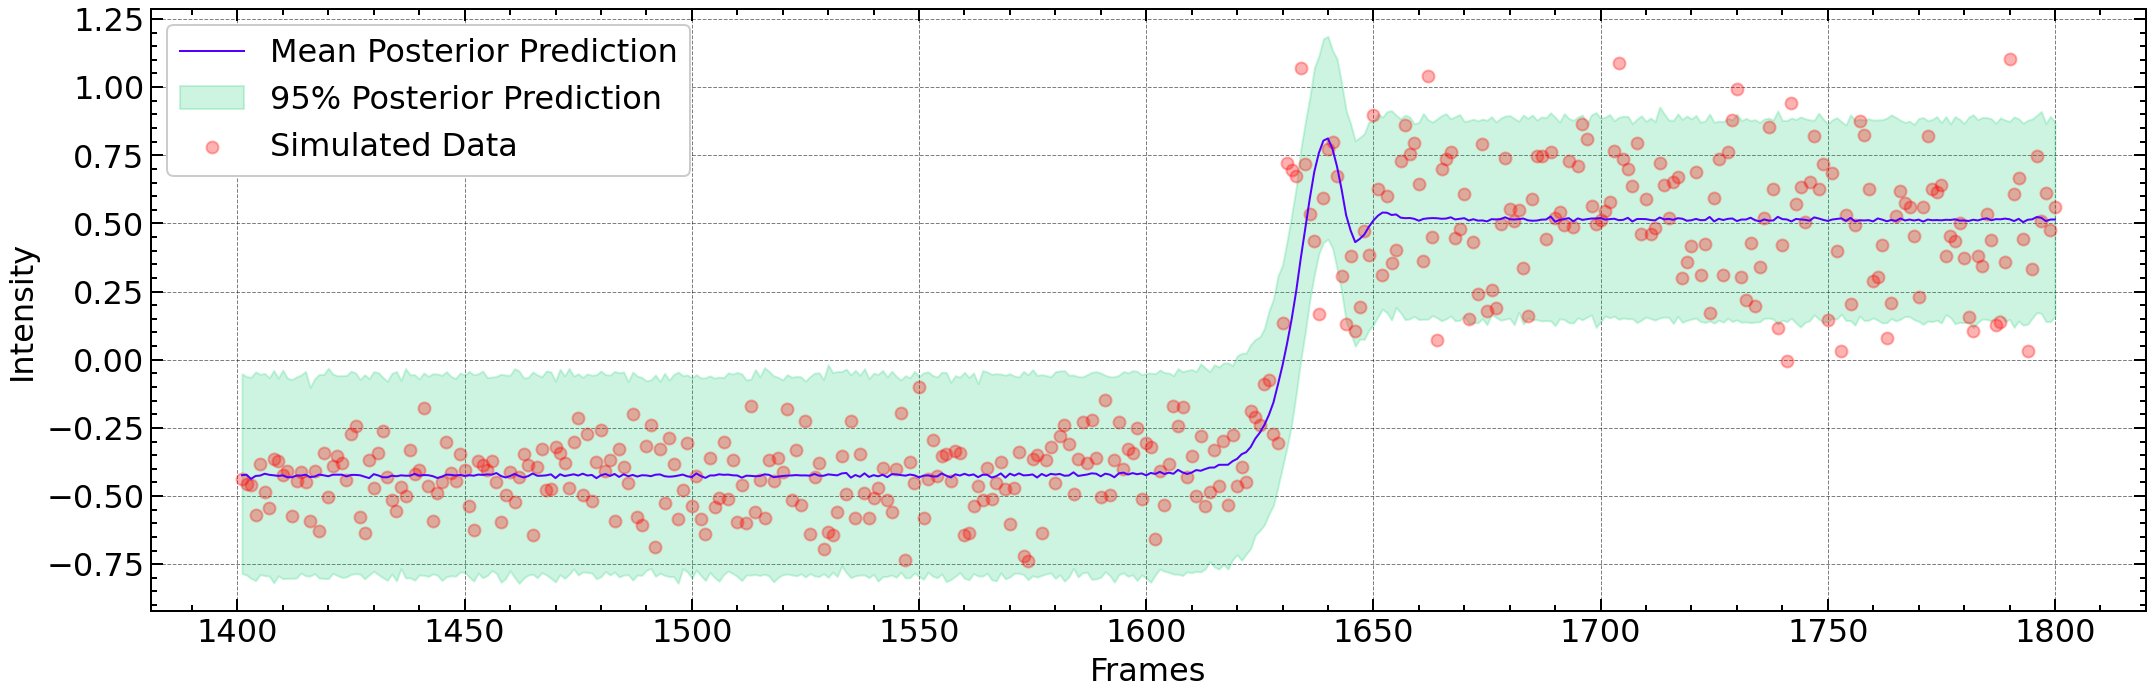

In [56]:
plt.figure(figsize=(15,5))
plt.plot(x_data2, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data2, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data2, value2_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(1850, 2050)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')

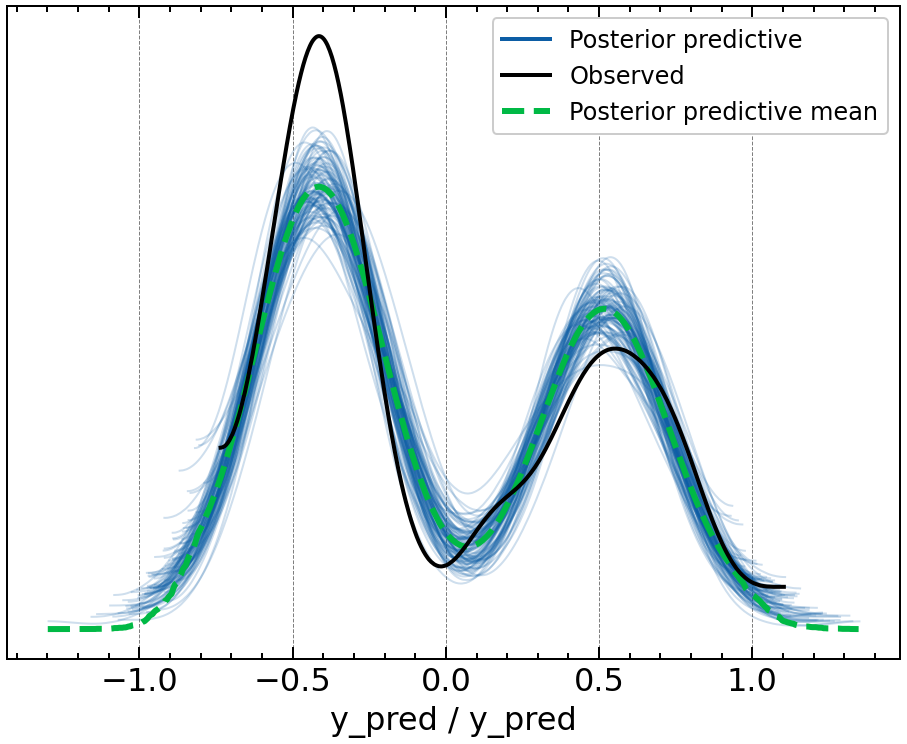

In [57]:
az.plot_ppc(idata, num_pp_samples=100);